In [ ]:
# ============================================================================
# Multi-Class Image Classification using CNN (Keras-TensorFlow) on Caltech Subset
# ============================================================================
# This full pipeline includes:
# - Dataset download and preparation
# - CNN model definition and training
# - Evaluation on test set
# - Metrics: classification report, confusion matrix
# - Visualization of sample predictions
# ============================================================================


In [17]:
# ============================================================================
# Dataset Preparation: Download and Extract Belgian Traffic Sign Dataset
# ============================================================================
# This section:
# 1. Removes any previously downloaded or extracted folders.
# 2. Downloads the dataset ZIP file from a remote link.
# 3. Extracts its contents into the /content directory.
# 4. Sets the training and test dataset paths for use in model training.
# ============================================================================
import zipfile
import os

# ==============================
# Step 1: Clean Previous Folders
# ==============================
!rm -f /content/download
!rm -rf /content/imagedb/
!rm -rf /content/imagedb_test/
!rm -rf /content/caltech/

# ==============================
# Step 2: Download the Dataset
# ==============================
!wget -O /content/dataset.zip https://vc.ee.duth.gr:6960/index.php/s/LyS24AwLJ1eAxFR/download

# ==============================
# Step 3: Extract the ZIP File
# ==============================
zip_path = '/content/dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# ==============================
# Step 4: Define Train/Test Directories
# ==============================
train_dir = '/content/caltech/imagedb'
test_dir = '/content/caltech/imagedb_test'

# Confirm
print("[INFO] Dataset extracted successfully.")
print(f"[INFO] Training data directory: {train_dir}")
print(f"[INFO] Test data directory: {test_dir}")


--2025-06-24 19:49:34--  https://vc.ee.duth.gr:6960/index.php/s/LyS24AwLJ1eAxFR/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14310142 (14M) [application/zip]
Saving to: ‘/content/dataset.zip’

/content/dataset.zi 100%[===================>]  13.65M  6.46MB/s    in 2.1s    

2025-06-24 19:49:37 (6.46 MB/s) - ‘/content/dataset.zip’ saved [14310142/14310142]

[INFO] Dataset extracted successfully.
[INFO] Training data directory: /content/caltech/imagedb
[INFO] Test data directory: /content/caltech/imagedb_test


In [18]:
# ================================================================================
# Model Definition: Simple CNN Architecture for Multi-Class Image Classification
# ================================================================================
# This block builds a basic Convolutional Neural Network using Keras Sequential API.
# - It includes two convolutional blocks followed by dense layers.
# - The final layer uses softmax activation for multi-class output (5 traffic sign classes).
# - The model is compiled using sparse categorical crossentropy and Adam optimizer.
# ================================================================================

import tensorflow as tf
from keras import models, layers

# Define number of classes
num_classes = 5

# Build the model
model = models.Sequential()

# Input + Conv Layer
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D())

# Add more convolution if needed
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D())

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,750,885 (60.08 MB)

 Trainable params: 15,750,885 (60.08 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ==========================================================================================
# Data Preprocessing: Train/Validation Generators with Augmentation using ImageDataGenerator
# ==========================================================================================
# This section sets up real-time data generators for training and validation using Keras.
# - Applies image rescaling (normalization) and augmentation (rotation, zoom, shear).
# - Uses a 20% validation split from the training dataset.
# - Data is loaded in batches of 20 and resized to 256x256 pixels.
# - `class_mode='sparse'` is used to output integer labels compatible with sparse loss.
# ==========================================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    width_shift_range=0.0,
    height_shift_range=0.0,
    rotation_range=40,
    shear_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='sparse',     # <--- integer labels
    target_size=(256,256),
    shuffle=True,
    subset='training',
    seed=1
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='sparse',     # <--- integer labels
    target_size=(256,256),
    subset='validation',
    seed=1
)


Found 388 images belonging to 5 classes.
Found 94 images belonging to 5 classes.


In [20]:
# ====================================================================================
# Training Setup: Callbacks and Model Fitting
# ====================================================================================
# This section configures callbacks to:
# - Save the best model during training (`ModelCheckpoint`) based on validation loss.
# - Stop training early (`EarlyStopping`) if no improvement is observed after 10 epochs.
# Then it trains the CNN model using the training and validation generators.
# The final trained model is saved to disk as a .keras file.
# ====================================================================================

import tensorflow as tf

# Define callbacks
callbacks = []

# Save the best model based on validation loss
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights_caltech.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Stop training early if no improvement for 10 epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    verbose=1
)
callbacks.append(early_stop_callback)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)

# Save the final model to file
model.save('small_last_caltech.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2703 - loss: 4.4728

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.19854, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2736 - loss: 4.4042 - val_accuracy: 0.5851 - val_loss: 1.1985
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5677 - loss: 1.1266
Epoch 2: val_loss improved from 1.19854 to 0.79497, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5710 - loss: 1.1210 - val_accuracy: 0.8191 - val_loss: 0.7950
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7925 - loss: 0.6501
Epoch 3: val_loss improved from 0.79497 to 0.55452, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7932 - loss: 0.6470 - val_accuracy: 0.7766 - val_loss: 0.5545
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8278 - loss: 0.4497
Epoch 4: val_loss improved from 0.55452 to 0.45419, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 39

In [21]:
# ====================================================================================
# Evaluation on Test Data
# ====================================================================================
# This section sets up a test data generator without data augmentation and uses it
# to evaluate the final trained model. The generator loads test images from disk,
# rescales them, and feeds them into the model for accuracy and loss computation.
# ====================================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale only (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images from directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=20,
    class_mode='sparse',         # Sparse for integer labels
    target_size=(256, 256),
    shuffle=False                # Preserve order for consistent evaluation
)

# Evaluate the model
loss, acc = model.evaluate(test_generator)

# Print results
print(f"\n[RESULT] Test Accuracy: {acc:.4f}")
print(f"[RESULT] Test Loss: {loss:.4f}")


Found 52 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.9558 - loss: 0.2132

[RESULT] Test Accuracy: 0.9615
[RESULT] Test Loss: 0.1802


In [22]:
# ====================================================================================
# Prediction and Evaluation Metrics
# ====================================================================================
# This section performs predictions on the test dataset using the trained model.
# It calculates predicted class labels, retrieves true labels, and sets up class names
# for further evaluation (classification report, confusion matrix, etc.).
# ====================================================================================

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert softmax output to predicted class index

# True labels from the generator
y_true = test_generator.classes

# Class labels (based on folder names)
class_names = list(test_generator.class_indices.keys())


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


In [23]:
# ====================================================================================
# Classification Report & Confusion Matrix Visualization
# ====================================================================================
# This section prints a detailed classification report including precision, recall,
# and F1-score for each class. It also visualizes the confusion matrix using Seaborn
# to give insights into model performance across all categories.
# ====================================================================================

print("[Classification Report]")
print(classification_report(y_true, y_pred, target_names=class_names))


[Classification Report]
                    precision    recall  f1-score   support

145.motorbikes-101       0.91      1.00      0.95        10
    178.school-bus       1.00      0.89      0.94         9
  224.touring-bike       0.92      1.00      0.96        11
 251.airplanes-101       1.00      0.91      0.95        11
  252.car-side-101       1.00      1.00      1.00        11

          accuracy                           0.96        52
         macro avg       0.97      0.96      0.96        52
      weighted avg       0.96      0.96      0.96        52



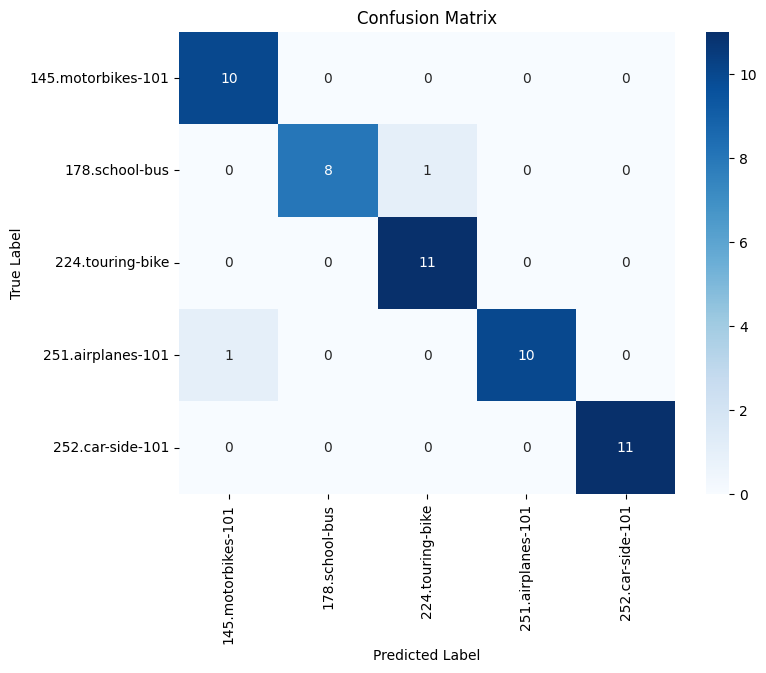

In [24]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


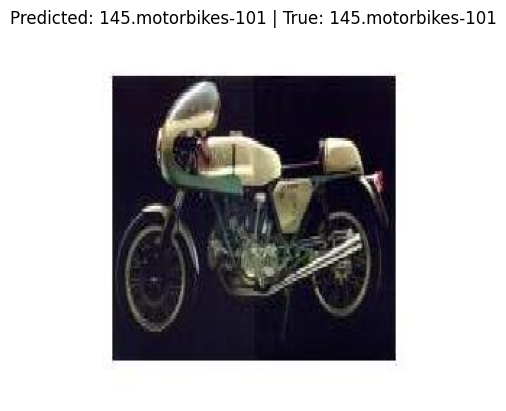

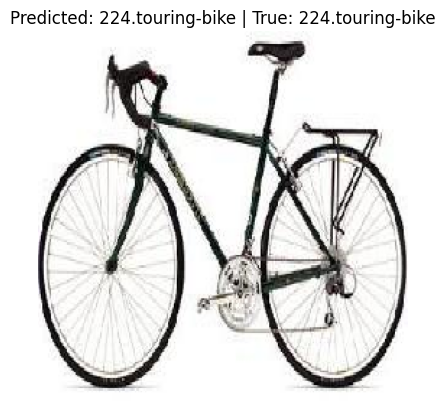

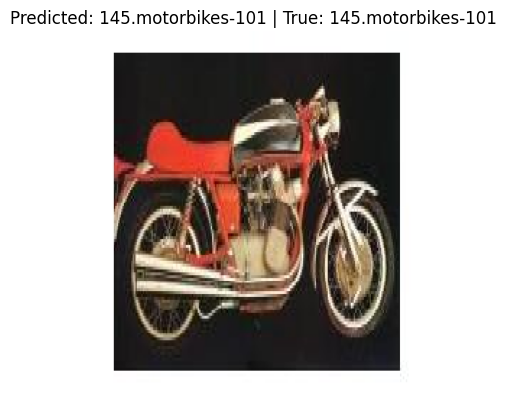

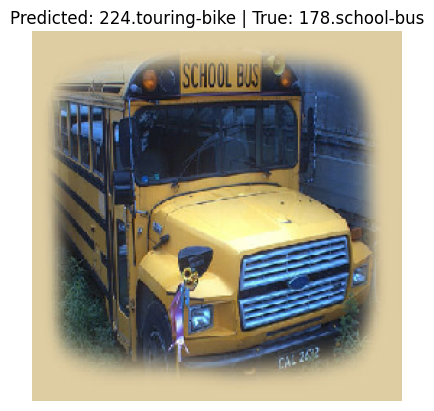

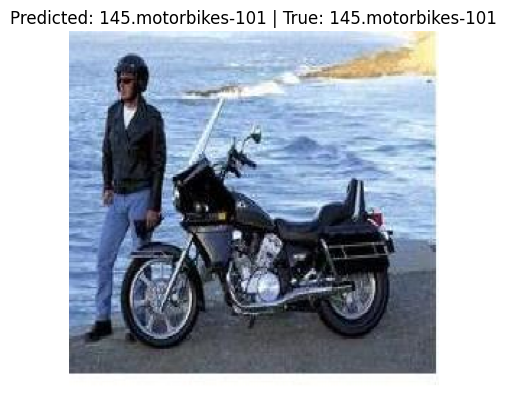

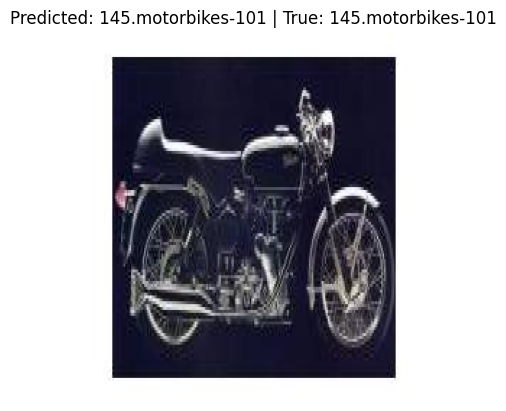

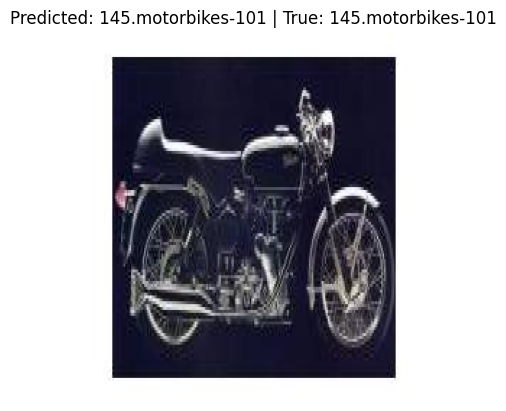

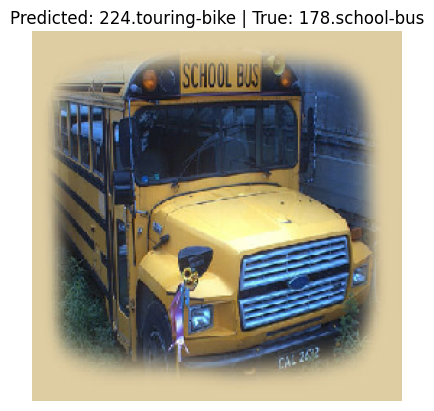

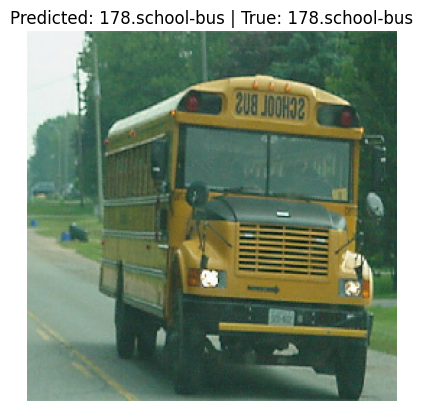

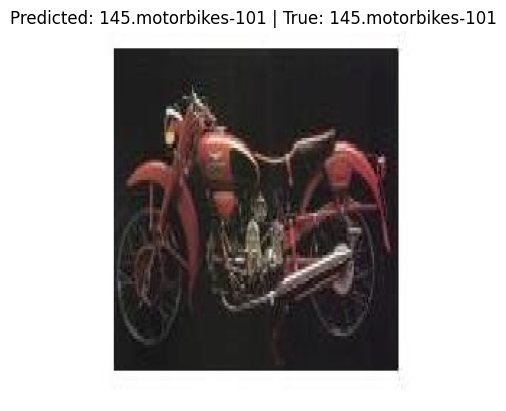

In [26]:
# ====================================================================================
# Sample Prediction Visualization
# ====================================================================================
# This block selects 10 random images from the test set, predicts their labels using
# the trained CNN model, and displays them alongside their true labels. It provides
# a qualitative understanding of how well the model performs on unseen data.
# ====================================================================================

import matplotlib.pyplot as plt
import numpy as np
import random

# Get one full batch of test images and true labels
images, labels = next(test_generator)

# Predict classes using the trained model
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Get class name mapping
class_names = list(test_generator.class_indices.keys())

# Display 10 random test images with predicted vs. true label
for i in range(10):
    idx = random.randint(0, len(images) - 1)

    plt.imshow(images[idx])
    plt.title(f"Predicted: {class_names[predicted_classes[idx]]} | True: {class_names[int(labels[idx])]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
